In [36]:
import sys
import numpy as np
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

In [37]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def showImage(img, size=6):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype('uint8')           # Меняем тип на однобайтовый без знака
  img = Image.fromarray(img)          # Переводим массив в изображение

  plt.figure(figsize=(size, size))
  plt.imshow(img)                     # Отрисовываем картинку
  plt.show()                          # Выводим картинку

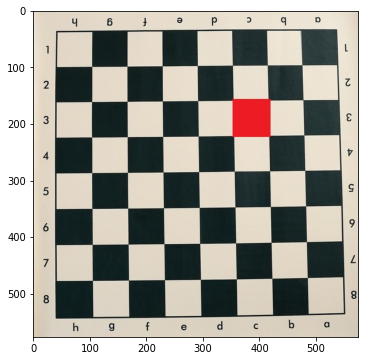

In [48]:
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Machine learning/Images/5_Find_boxes_in_video/object_on_chesstablejpg.jpg")
showImage(image)

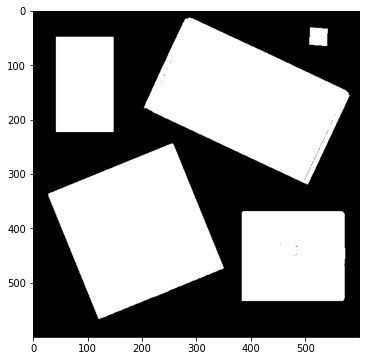

In [40]:
# Найдем контуры изображений

# Параметры для маски
hsv_min = np.array((0, 5, 0), np.uint8)
hsv_max = np.array((250, 250, 255), np.uint8)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # меняем цветовую модель с BGR на HSV
image_filter = cv2.inRange(hsv, hsv_min, hsv_max) # применяем цветовой фильтр
showImage(image_filter)

In [41]:
# Найдем контуры всех фигур на изображении
contours_list, _ = cv2.findContours(image_filter.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # _ - игнорирум 2 возращаемый параметр

In [42]:
print("Количество найденных фигур:", len(contours_list))
print("Координаты одной из фигур:\n", contours_list[5], end="")

Количество найденных фигур: 64
Координаты одной из фигур:
 [[[481 432]]

 [[482 431]]

 [[483 432]]

 [[482 433]]]

In [43]:
# Находим среди всех контуров только прямоугольники
def getBoxes(contours_list, min_area, max_area = 1000000):
  boxes = []
  for contour in contours_list:
    rect = cv2.minAreaRect(contour) # пытаемся вписать прямоугольник
    box = cv2.boxPoints(rect) # ищем четыре вершины у прямоугольника
    box = np.int0(box) # округляем координаты до целого числа
    area = cv2.contourArea(box) # вычисляем площадь, занимаемую прямоугольником
    if (area > min_area) & (area < max_area):
      boxes.append(box)
  return boxes

# Рисуем фигуры на изображении
def grawContours(img, boxes):
  img_out = img.copy()
  for box in boxes:
    cv2.drawContours(img_out, [box], 0, (255,0,0), 2) # рисуем прямоугольник # 0 - неизвестно # (255,0,0) - цвет # 2 - толщина
  return img_out

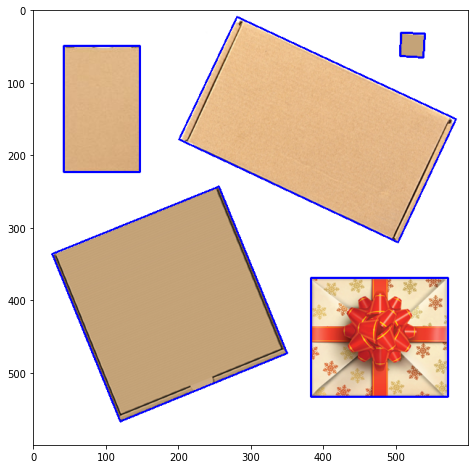

In [44]:
# Находим наши коробки

boxes = getBoxes(contours_list, 700, 150200) # находим среди всех контуров только прямоугольники нужного размера
image_out = grawContours(image, boxes) # наносим прямоугольники на исходное изображение
showImage(image_out, 8)

In [45]:
def calcAngle(box):
  # Находим центр фигуры. Запишем их в список center
  center = (
      (int((box[0][0]+box[1][0]+box[2][0]+box[3][0])/4)), # Находим центр Х
      (int((box[0][1]+box[1][1]+box[2][1]+box[3][1])/4)) # Находим центр У
  )

  # Находим длины двух сторон прямоугольника: вертикальную и горизонтальную
  edge1 = np.int0((box[1][0] - box[0][0], box[1][1] - box[0][1]))
  edge2 = np.int0((box[2][0] - box[1][0], box[2][1] - box[1][1]))

  # Определяем наиболее длинную сторону прямоугольника
  if cv2.norm(edge2) > cv2.norm(edge1):
    usedEdge = edge1
  else:
    usedEdge = edge2

  # Определем горизонтальную сторону
  reference = (1,0)

  # Вычисляем угол между самой длинной стороной прямоугольника и горизонтом
  angle = 180.0/math.pi * math.acos((reference[0]*usedEdge[0] + reference[1]*usedEdge[1]) / (cv2.norm(reference) *cv2.norm(usedEdge)))

  return center, angle

def drawAngle(img, center, angle):
  img_out = img.copy()

  # Рисуем круг в центре прямоугольника
  cv2.circle(img_out, center, 3, (10,200,10), 5) # 3 - радиус зеленого круга

  # Выводим величину угла наклона
  cv2.putText(img_out, "%d" % int(angle), (center[0]+10, center[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)

  return img_out

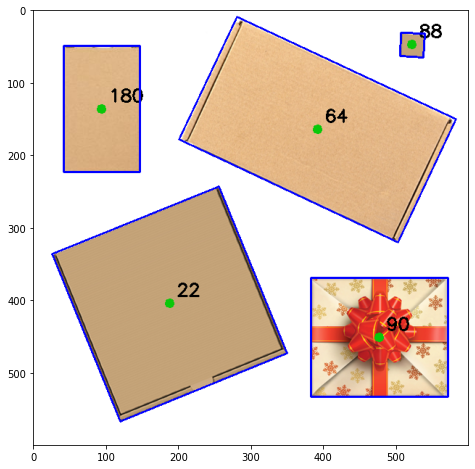

In [46]:
# Наносим прямоугольники и углы поворота

image_done = image.copy()
for box in boxes:
  center, angle = calcAngle(box)
  image_done = grawContours(image_done, boxes) # наносим прямоугольники на исходное изображение
  image_done = drawAngle(image_done, center, angle) # наносим центры прямоугольников и угол поворота относительно горизонта

showImage(image_done, 8)